In [1]:
import numpy as np
import pandas as pd
import csv
# from ta import *
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import ga
from utils import *

In [2]:
def count_trade_no(signal):
    no_trades = 0
    prev = 10
    for i in signal:
        if i != prev and prev != 0:
            prev = i
            no_trades += 1
    return no_trades

def ema(series, n):
    return series.ewm(span=n, min_periods=n).mean()

def ma(close, n):
    return close.rolling(n).mean()
    
def DEMA(close, n):
    EMA = ema(close, n)
    return 2*EMA - ema(EMA,n)

def TEMA(close, n):
    EMA = ema(close, n)
    EEMA = ema(EMA, n)
    return 3*EMA - 3*EEMA + ema(EEMA, n)

def rsi(close, n=14):
    diff = close.diff(1)
    which_dn = diff < 0
    up, dn = diff, diff*0
    up[which_dn], dn[which_dn] = 0, -up[which_dn]
    emaup = ema(up, n)
    emadn = ema(dn, n)
    rsi = 100 * emaup / (emaup + emadn)
    return pd.Series(rsi, name='rsi')

def stoch(high, low, close, n=14, fillna=False):
    smin = low.rolling(n, min_periods=0).min()
    smax = high.rolling(n, min_periods=0).max()
    stoch_k = 100 * (close - smin) / (smax - smin)
    return pd.Series(stoch_k, name='stoch_k')

def stoch_signal(high, low, close, n=14, d_n=3, fillna=False):
    stoch_k = stoch(high, low, close, n, fillna=fillna)
    stoch_d = stoch_k.rolling(d_n, min_periods=0).mean()

    if fillna:
        stoch_d = stoch_d.replace([np.inf, -np.inf], np.nan).fillna(50)
    return pd.Series(stoch_d, name='stoch_d')

def average_true_range(high, low, close, n=14, fillna=False):
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)

    atr = np.zeros(len(close))
    atr[0] = tr[1::].mean()
    for i in range(1, len(atr)):
        atr[i] = (atr[i-1] * (n-1) + tr.iloc[i]) / float(n)

    atr = pd.Series(data=atr, index=tr.index)
    return pd.Series(atr, name='atr')

def vortex_indicator_pos(high, low, close, n=14, fillna=False):
    tr = (high.combine(close.shift(1), max)
          - low.combine(close.shift(1), min))
    trn = tr.rolling(n).sum()

    vmp = np.abs(high - low.shift(1))
    vmm = np.abs(low - high.shift(1))

    vip = vmp.rolling(n, min_periods=0).sum() / trn
    if fillna:
        vip = vip.replace([np.inf, -np.inf], np.nan).fillna(1)
    return pd.Series(vip, name='vip')


def vortex_indicator_neg(high, low, close, n=14, fillna=False):
    tr = high.combine(close.shift(1), max) - low.combine(close.shift(1), min)
    trn = tr.rolling(n).sum()

    vmp = np.abs(high - low.shift(1))
    vmm = np.abs(low - high.shift(1))

    vin = vmm.rolling(n).sum() / trn
    if fillna:
        vin = vin.replace([np.inf, -np.inf], np.nan).fillna(1)
    return pd.Series(vin, name='vin')

def cci(high, low, close, n=20, c=0.015):
    pp = (high + low + close) / 3.0
    cci = (pp - pp.rolling(n, min_periods=0).mean()) / (c * pp.rolling(n, min_periods=0).std())
    return pd.Series(cci, name='cci')

def bollinger_mavg(close, n=20, fillna=False):
    mavg = close.rolling(n, min_periods=0).mean()
    if fillna:
        mavg = mavg.replace(
            [np.inf, -np.inf], np.nan).fillna(method='backfill')
    return pd.Series(mavg, name='mavg')

def bollinger_hband(close, n=20, ndev=2, fillna=False):
    mavg = close.rolling(n, min_periods=0).mean()
    mstd = close.rolling(n, min_periods=0).std()
    hband = mavg + ndev*mstd
    return pd.Series(hband, name='hband')

def bollinger_lband(close, n=20, ndev=2, fillna=False):
    mavg = close.rolling(n, min_periods=0).mean()
    mstd = close.rolling(n, min_periods=0).std()
    lband = mavg - ndev * mstd
    return pd.Series(lband, name='lband')

def keltner_channel_hband(high, low, close, n=10, fillna=False):
    tp = ((4 * high) - (2 * low) + close) / 3.0
    tp = tp.rolling(n, min_periods=0).mean()
    if fillna:
        tp = tp.replace([np.inf, -np.inf], np.nan).fillna(method='backfill')
    return pd.Series(tp, name='kc_hband')

def keltner_channel_lband(high, low, close, n=10):
    tp = ((-2 * high) + (4 * low) + close) / 3.0
    tp = tp.rolling(n, min_periods=0).mean()
    return pd.Series(tp, name='kc_lband')

def donchian_channel_hband(close, n=20, fillna=False):
    hband = close.rolling(n, min_periods=0).max()
    if fillna:
        hband = hband.replace(
            [np.inf, -np.inf], np.nan).fillna(method='backfill')
    return pd.Series(hband, name='dchband')


def donchian_channel_lband(close, n=20, fillna=False):
    lband = close.rolling(n, min_periods=0).min()
    if fillna:
        lband = lband.replace(
            [np.inf, -np.inf], np.nan).fillna(method='backfill')
    return pd.Series(lband, name='dclband')


def ichimoku_a(high, low, n1=9, n2=26, visual=False, fillna=False):
    conv = 0.5 * (high.rolling(n1, min_periods=0).max() + low.rolling(n1, min_periods=0).min())
    base = 0.5 * (high.rolling(n2, min_periods=0).max() + low.rolling(n2, min_periods=0).min())

    spana = 0.5 * (conv + base)

    if visual:
        spana = spana.shift(n2)

    if fillna:
        spana = spana.replace([np.inf, -np.inf], np.nan).fillna(method='backfill')

    return pd.Series(spana, name='ichimoku_a_'+str(n2))


def ichimoku_b(high, low, n2=26, n3=52, visual=False, fillna=False):
    spanb = 0.5 * (high.rolling(n3, min_periods=0).max() + low.rolling(n3, min_periods=0).min())

    if visual:
        spanb = spanb.shift(n2)

    if fillna:
        spanb = spanb.replace([np.inf, -np.inf], np.nan).fillna(method='backfill')

    return pd.Series(spanb, name='ichimoku_b_'+str(n2))



# Type 1 Rules:
# > ma with ma
# > ema with ma
# > ema with ema
# > dema with ma
# > deme with dema
# > tema with tema
# > tema with ma

def Rule1(param):
    # Rule 1: Simple Moving Average Crossover
    # Input: Close prices, MA periods 1 and 2
    # Return: training periods accumulated returns
    ma1, ma2 = param
    s1 = close.rolling(ma1).mean()
    s2 = close.rolling(ma2).mean()
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule2(param):
    # Rule 2: EMA and close
    # Input: Close prices, EMA periods 1 and 2
    # Return: training periods accumulated returns
    ema1, ma2 = param
    s1 = ema(close, ema1)
    s2 = close.rolling(ma2).mean()
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule3(param):
    # Rule 3: EMA and EMA
    # Input: Close prices, EMA periods 1 and 2
    # Return: training periods accumulated returns
    ema1, ema2 = param
    s1 = ema(close, ema1)
    s2 = ema(close, ema2)
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule4(param):
    # Rule 4: DEMA and MA
    dema1, ma2 = param
    s1 = DEMA(close, dema1)
    s2 = close.rolling(ma2).mean()
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule5(param):
    # Rule 5: DEMA and DEMA
    dema1, dema2 = param
    s1 = DEMA(close, dema1)
    s2 = DEMA(close, dema2)
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule6(param):
    # Rule 6: TEMA and ma crossovers
    tema1, ma2 = param
    s1 = TEMA(close, tema1)
    s2 = close.rolling(ma2).mean()
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule7(param):
    stoch1, stochma2 = param
    s1 = stoch(high, low, close, stoch1)
    s2 = s1.rolling(stochma2, min_periods=0).mean()
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule8(param):
    vortex1, vortex2 = param
    s1 = vortex_indicator_pos(high, low, close, vortex1)
    s2 = vortex_indicator_neg(high, low, close, vortex2)
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule9(param):
    p1, p2 = param
    s1 = ichimoku_a(high, low, n1=p1, n2=round((p1+p2)/2))
    s2 = ichimoku_b(high, low, n2=round((p1+p2)/2), n3=p2)
    s3 = close
    signal = (-1*((s3>s1) & (s3>s2))+1*((s3<s2) & (s3<s1))).shift(1)
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

# Type 2 Rules:
# > RSI
# > CCI *High must be greater than low

def Rule10(param):
    rsi1, c2 = param
    s1 = rsi(close, rsi1)
    s2 = c2
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule11(param):
    cci1, c2 = param
    s1 = cci(high, low, close, cci1)
    s2 = c2
    signal = 2*(s1<s2).shift(1)-1
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)


# Type 3 Rules:
# > RSI
# > CCI
# ** High must be greater than low

def Rule12(param):
    rsi1, hl, ll = param
    s1 = rsi(close, rsi1)
    signal = (-1*(s1>hl)+1*(s1<ll)).shift(1)
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule13(param):
    cci1, hl, ll = param
    s1 = cci(high, low, close, cci1)
    signal = (-1*(s1>hl)+1*(s1<ll)).shift(1)
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)


# Type 4 Rules:
# > Bollinger-bands high, low
# > keltner_channel
# > donchian_channel
# > ichimoko a and b

def Rule14(period):
    s1 = keltner_channel_hband(high, low, close, n=period)
    s2 = keltner_channel_lband(high, low, close, n=period)
    s3 = close
    signal = (-1*(s3>s1)+1*(s3<s2)).shift(1)
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule15(period):
    s1 = donchian_channel_hband(close, n=period)
    s2 = donchian_channel_hband(close, n=period)
    s3 = close
    signal = (-1*(s3>s1)+1*(s3<s2)).shift(1)
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)

def Rule16(period):
    s1 = bollinger_hband(close, n=period)
    s2 = bollinger_lband(close, n=period)
    s3 = close
    signal = (-1*(s3>s1)+1*(s3<s2)).shift(1)
    port_logr = signal*logr
    return (abs(port_logr.sum()), signal)


,Open,High,Low,Close
0,1.28039,1.28061,1.27994,1.28001
1,1.28001,1.28001,1.27957,1.27980
2,1.27980,1.28081,1.27980,1.28000
3,1.28002,1.28092,1.28002,1.28092
4,1.28093,1.28121,1.28073,1.28098


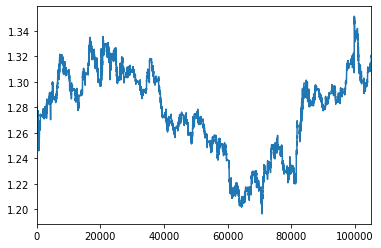

In [5]:
data = pd.read_csv("GBPUSD_M5.csv")
data = data[['Open', 'High', 'Low', 'Close']]

# data = pd.read_csv('EUR_USD_daily.csv')
# data = data.rename(columns = {'Price':'Close'})
# data = data.reindex(index=data.index[::-1])
# data.reset_index(drop=True, inplace = True)
data.head()
data.Close.plot()

In [6]:
split = len(data)//2
X_train = data.loc[:split-1]
X_test = data.loc[split:]

## Tuning parameter for the Rules using Training data

In [7]:
close = X_train.Close
high = X_train.High
low = X_train.Low
logr = np.log(close/close.shift(1))

periods = [1, 3, 5, 7, 11, 15, 19, 23, 27, 35, 41, 50, 61]
type1 = [Rule1, Rule2, Rule3, Rule4, Rule5, Rule6, Rule7, Rule8, Rule9]
type1_param = []
type1_score = []
for rule in type1:
    n = len(periods)
    best = -1
    for i in range(n):
        for j in range(i, n):
            score = rule((periods[i], periods[j]))[0]
            if score>best:
                best = score
                best_param = (periods[i], periods[j])
    type1_param.append(best_param)
    type1_score.append(best)

In [8]:
rsi_limits = list(range(0,101,5))
cci_limits = list(range(-120, 121, 20))
limits = [rsi_limits, cci_limits]

type2 = [Rule10, Rule11]
type2_param = []
type2_score = []

for i in range(len(type2)):
    rule = type2[i]
    params = limits[i]
    n = len(params)
    best = -1
    for period in periods:
        for lim in params:
            score = rule((period, lim))[0]
            if score>best:
                best = score
                best_param = (period, lim)
    type2_param.append(best_param)
    type2_score.append(best)

In [9]:
type3 = [Rule12, Rule13]
type3_param = []
type3_score = []

for i in range(len(type3)):
    rule = type3[i]
    params = limits[i]
    n = len(params)
    best = -1
    for period in periods:
        for lb in range(n-1):
            for ub in range(lb+1, n):
                score = rule((period, params[ub], params[lb]))[0]
                if score>best:
                    best = score
                    best_param = (period, params[ub], params[lb])
    type3_param.append(best_param)
    type3_score.append(best)

In [10]:
type4 = [Rule14, Rule15, Rule16]
type4_param = []
type4_score = []

for rule in type4:
    best = -1
    for i in periods:
        score = rule(i)[0]
        if score>best:
            best = score
            best_param = i
    type4_param.append(best_param)
    type4_score.append(best)

In [11]:
type1_param, type1_score
type2_param, type2_score
type3_param, type3_score
type4_param, type4_score

([(1, 7), (1, 7), (1, 5), (3, 3), (1, 41), (1, 7), (15, 41), (1, 5), (3, 3)],
 [0.3270295820130014,
  0.3259060895546284,
  0.35294591844593676,
  0.3616539557304708,
  0.3157107787945108,
  0.3259060895546284,
  0.31569062581954593,
  0.26947490616695774,
  0.32295390343675207])

([(5, 50), (3, 20)], [0.35294591844593676, 0.31184259048765045])

([(5, 50, 45), (3, 40, 20)], [0.3385707152085699, 0.3027991730354831])

([15, 3, 61], [0.2222026687433677, 0.13032674541636555, 0.10159583779660417])

In [12]:
All_Rules = type1+type2+type3+type4
Rule_params = type1_param+type2_param+type3_param+type4_param
Rule_scores = type1_score+type2_score+type3_score+type4_score

In [13]:
for i in range(len(All_Rules)):
    print('Training Rule{} score is: {:.3f}'.format(i+1, Rule_scores[i]))

Training Rule1 score is: 0.327
Training Rule2 score is: 0.326
Training Rule3 score is: 0.353
Training Rule4 score is: 0.362
Training Rule5 score is: 0.316
Training Rule6 score is: 0.326
Training Rule7 score is: 0.316
Training Rule8 score is: 0.269
Training Rule9 score is: 0.323
Training Rule10 score is: 0.353
Training Rule11 score is: 0.312
Training Rule12 score is: 0.339
Training Rule13 score is: 0.303
Training Rule14 score is: 0.222
Training Rule15 score is: 0.130
Training Rule16 score is: 0.102


In [14]:
close = X_test.Close
high = X_test.High
low = X_test.Low
logr = np.log(close/close.shift(1))

for i in range(len(All_Rules)):
    rule = All_Rules[i]
    score = rule(Rule_params[i])[0]
    print('Testing Rule{} score is: {:.3f}'.format(i+1, score))

Testing Rule1 score is: 0.221
Testing Rule2 score is: 0.235
Testing Rule3 score is: 0.319
Testing Rule4 score is: 0.285
Testing Rule5 score is: 0.192
Testing Rule6 score is: 0.235
Testing Rule7 score is: 0.257
Testing Rule8 score is: 0.157
Testing Rule9 score is: 0.279
Testing Rule10 score is: 0.319
Testing Rule11 score is: 0.272
Testing Rule12 score is: 0.311
Testing Rule13 score is: 0.272
Testing Rule14 score is: 0.212
Testing Rule15 score is: 0.188
Testing Rule16 score is: 0.059


In [15]:
close = X_train.Close
high = X_train.High
low = X_train.Low
logr = np.log(close/close.shift(1))

train_df = pd.DataFrame({'logr': logr})
for i in range(len(All_Rules)):
    train_df['Rule'+str(i+1)] = All_Rules[i](Rule_params[i])[1]
train_df.dropna(inplace = True)
# train_df.head()

In [16]:
close = X_test.Close
high = X_test.High
low = X_test.Low
logr = np.log(close/close.shift(1))

test_df = pd.DataFrame({'logr': logr})
for i in range(len(All_Rules)):
    test_df['Rule'+str(i+1)] = All_Rules[i](Rule_params[i])[1]
test_df.dropna(inplace = True)
# test_df.head()

# Benchmark Models

In [17]:
def evaluate_train(position):
    port_r_train = logr_train*position
    train_score = port_r_train.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("Training period (35 weeks) return: {:.2f}%".format(train_score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r_train.cumsum())*100))
    sr_train = port_r_train.mean()/port_r_train.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))
    
def evaluate_test(position):
    port_r_test = logr_test*position
    test_score = port_r_test.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("Testing period (35 weeks) return: {:.2f}%".format(test_score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r_test.cumsum())*100))
    sr_test = port_r_test.mean()/port_r_test.std()*(252*24*12)**0.5
    print("SR ratio is: {:.3f}".format(sr_test))

In [18]:
X_train_df = train_df.copy()
X_test_df = test_df.copy()
logr_train = X_train_df['logr']
logr_test = X_test_df['logr']
X_train_df.drop(['logr'], axis = 1, inplace = True)
X_test_df.drop(['logr'], axis = 1, inplace = True)
y_train = 2*(logr_train>0)-1
y_test = 2*(logr_test>0)-1

In [19]:
print("simple buy and hold")
position = logr_train*0+1
evaluate_train(position)
print()
position = logr_test*0+1
evaluate_test(position)

simple buy and hold
The maximum position is 1.000, the mean postiion is 1.000000.
Training period (35 weeks) return: -1.23%
Maximum drawdown is: -2.706%
SR ratio is: -0.233

The maximum position is 1.000, the mean postiion is 1.000000.
Testing period (35 weeks) return: 4.27%
Maximum drawdown is: -5.530%
SR ratio is: 0.760


In [20]:
print("simple sell and hold")
position = logr_train*0-1
evaluate_train(position)
print()
position = logr_test*0-1
evaluate_test(position)

simple sell and hold
The maximum position is -1.000, the mean postiion is 1.000000.
Training period (35 weeks) return: 1.23%
Maximum drawdown is: -4.245%
SR ratio is: 0.233

The maximum position is -1.000, the mean postiion is 1.000000.
Testing period (35 weeks) return: -4.27%
Maximum drawdown is: -6.660%
SR ratio is: -0.760


In [21]:
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
_ = rf.fit(X_train_df, y_train) 
print(classification_report(y_test, rf.predict(X_test_df)))

from sklearn import svm
svc = svm.LinearSVC()
_ = svc.fit(X_train_df, y_train) 
print(classification_report(y_test, svc.predict(X_test_df)))

              precision    recall  f1-score   support

          -1       0.70      0.86      0.77     34462
           1       0.52      0.30      0.38     18097

    accuracy                           0.66     52559
   macro avg       0.61      0.58      0.58     52559
weighted avg       0.64      0.66      0.64     52559

              precision    recall  f1-score   support

          -1       0.73      0.76      0.74     34462
           1       0.50      0.47      0.49     18097

    accuracy                           0.66     52559
   macro avg       0.62      0.61      0.62     52559
weighted avg       0.65      0.66      0.66     52559



In [22]:
print("Random Forest Model")
position = rf.predict(X_train_df)
evaluate_train(position)
print()
position = rf.predict(X_test_df)
evaluate_test(position)

Random Forest Model
The maximum position is 1.000, the mean postiion is 1.000000.
Training period (35 weeks) return: 27.43%
Maximum drawdown is: -0.520%
SR ratio is: 5.214

The maximum position is 1.000, the mean postiion is 1.000000.
Testing period (35 weeks) return: 24.83%
Maximum drawdown is: -0.105%
SR ratio is: 4.419


In [23]:
print("SVC model")
position = svc.predict(X_train_df)
evaluate_train(position)
print()
position = svc.predict(X_test_df)
evaluate_test(position)

SVC model
The maximum position is 1.000, the mean postiion is 1.000000.
Training period (35 weeks) return: 24.28%
Maximum drawdown is: -0.972%
SR ratio is: 4.615

The maximum position is 1.000, the mean postiion is 1.000000.
Testing period (35 weeks) return: 25.23%
Maximum drawdown is: -0.014%
SR ratio is: 4.490


## Genetic Algorithm to Find the Optimal Combination of Rules

In [24]:
def cal_pop_fitness(equation_inputs, pop, opt = 0):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    # fitness = np.sum(pop*equation_inputs, axis=1)
    logr = equation_inputs[:,0] # n,
    positions = pop@equation_inputs[:,1:].T # pop 8x16, 16xn --- 8xn
    port_r = (positions*logr).astype(np.float64)
    
    # 1 Fitness score is calculated as: Total return/total money
    # Interpreted as return per dollar invested
    if opt == 0:
        fitness = np.sum(port_r, axis = 1)/np.max(abs(positions),1)
    
    # 2 Fitness score used to minimize losses
    elif opt == 1:
        port_r[port_r>0] = 0
        fitness = np.sum(port_r, axis = 1)/np.max(abs(positions),1)
        
    # 3 Fitness score is calculated as the SR ratio
    elif opt == 2:
        fitness = np.mean(port_r, axis = 1)/np.std(port_r, axis = 1)/(-np.sum(port_r[port_r<0]))
    return fitness

In [25]:
def GA_module(training_df, optimizing_selection=0, sol_per_pop=8, num_parents_mating=4, num_generations = 200):
    """
    Genetic algorithm parameters:
        Mating pool size
        Population size
    """
    #Inputs of the equation.
    equation_inputs = training_df.values
    # Number of the weights we are looking to optimize.
    num_weights = training_df.shape[1]-1

    # Defining the population size.
    pop_size = (sol_per_pop,num_weights) 
    # The population will have sol_per_pop chromosome 
    # where each chromosome has num_weights genes.
    
    # Creating the initial population.
    new_population = np.random.uniform(low=-1.0, high=1.0, size=pop_size)
    # print(new_population)

    best_outputs = []
    
    for generation in range(num_generations):
    #     print("Generation : ", generation)
        # Measuring the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(equation_inputs, new_population, optimizing_selection)

        best_outputs.append(np.max(fitness))

        # Selecting the best parents in the population for mating.
        parents = ga.select_mating_pool(new_population, fitness, 
                                          num_parents_mating)

        # Generating next generation using crossover.
        offspring_crossover = ga.crossover(parents,
                                           offspring_size=(pop_size[0]-parents.shape[0], num_weights))

        # Adding some variations to the offspring using mutation.
        offspring_mutation = ga.mutation(offspring_crossover, num_mutations=2)

        # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation

    # Getting the best solution after iterating finishing all generations.
    # At first, the fitness is calculated for each solution in the final generation.
    fitness = cal_pop_fitness(equation_inputs, new_population, optimizing_selection)
    # Then return the index of that solution corresponding to the best fitness.
    best_match_idx = np.where(fitness == np.max(fitness))
    
    if optimizing_selection == 0:
        ylabel = "Return On Investment"
    elif optimizing_selection == 1:
        ylabel = 'Sum Negative Returns'
    elif optimizing_selection == 2:
        ylabel = 'Sharpe Ratio'
        
    plt.plot(best_outputs)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.show()
    return new_population[best_match_idx]

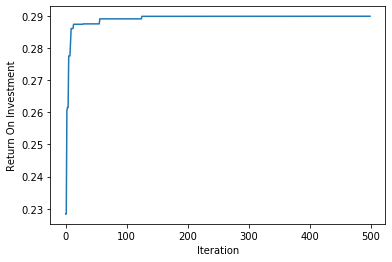

Optimal weights of rules using genetic algorithm:
Rule1: 0.090
Rule2: 0.607
Rule3: 0.952
Rule4: 0.938
Rule5: 0.683
Rule6: -0.227
Rule7: 0.354
Rule8: 0.052
Rule9: 0.388
Rule10: 0.760
Rule11: 0.410
Rule12: -0.361
Rule13: -0.377
Rule14: -0.057
Rule15: 0.559
Rule16: 0.059


In [26]:
max_return_weights = GA_module(train_df, optimizing_selection=0, sol_per_pop=8, num_parents_mating=4, num_generations = 500)

print("Optimal weights of rules using genetic algorithm:")
for i in range(max_return_weights.shape[1]):
    print("Rule{:}: {:.3f}".format(i+1, max_return_weights[0, i]))

In [27]:
position = (train_df.values[:, 1:]@max_return_weights.T).reshape(train_df.shape[0],)
position /= np.max(abs(position))
len(position)
evaluate_train(position)

52559

The maximum position is 1.000, the mean postiion is 0.566017.
Training period (35 weeks) return: 28.99%
Maximum drawdown is: -0.917%
SR ratio is: 7.500


In [28]:
position = (test_df.values[:, 1:]@max_return_weights.T).reshape(test_df.shape[0],)
position /= np.max(abs(position))
evaluate_test(position)

The maximum position is 1.000, the mean postiion is 0.552558.
Testing period (35 weeks) return: 23.91%
Maximum drawdown is: -0.090%
SR ratio is: 5.927


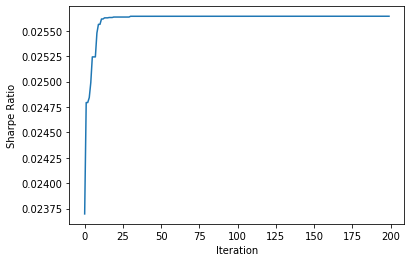

Optimal weights of rules using genetic algorithm:
Rule1: 0.396
Rule2: 0.374
Rule3: 0.661
Rule4: 0.516
Rule5: 0.657
Rule6: 0.789
Rule7: -0.853
Rule8: 0.720
Rule9: 0.363
Rule10: 0.500
Rule11: -0.105
Rule12: 0.096
Rule13: 0.772
Rule14: -0.981
Rule15: 0.444
Rule16: 2.453


In [29]:
max_SR_weights = GA_module(train_df, optimizing_selection=2, sol_per_pop=10, num_parents_mating=6, num_generations = 200)

print("Optimal weights of rules using genetic algorithm:")
for i in range(max_SR_weights.shape[1]):
    print("Rule{:}: {:.3f}".format(i+1, max_SR_weights[0, i]))

In [30]:
position = (train_df.values[:, 1:]@max_SR_weights.T).reshape(train_df.shape[0],)
position /= np.max(abs(position))
evaluate_train(position)
port_r_train = logr_train*position

The maximum position is 1.000, the mean postiion is 0.353485.
Training period (35 weeks) return: 17.67%
Maximum drawdown is: -0.688%
SR ratio is: 6.908


In [31]:
position = (test_df.values[:, 1:]@max_SR_weights.T).reshape(test_df.shape[0],)
position /= np.max(abs(position))
port_r_test = test_df.logr.values*position
evaluate_test(position)
port_r_test = logr_test*position

The maximum position is 1.000, the mean postiion is 0.370859.
Testing period (35 weeks) return: 12.98%
Maximum drawdown is: -0.077%
SR ratio is: 4.850


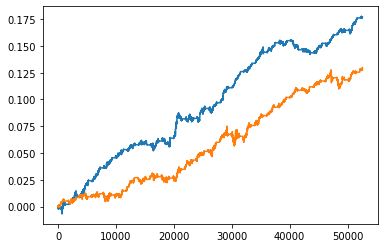

In [32]:
plt.plot(range(len(port_r_train)), port_r_train.cumsum())
plt.plot(range(len(port_r_test)), port_r_test.cumsum())


In [36]:
df = pd.DataFrame()
# df['train'] = port_r_train.values.cumsum()
df['test'] = port_r_test.values.cumsum()
df.to_csv('GBPUSD.csv')

In [34]:
stat = {'return': port_r_test.sum(), 'SR': port_r_test.mean()/port_r_test.std()*(252*24*12)**0.5, 
        "MD": min(port_r_train.cumsum())}

In [35]:
stat

{'MD': -0.006877695433808936,
 'SR': 4.850053141266083,
 'return': 0.12977427759871718}